In [24]:
# testing pretrained model
# %pip install torch torchvision matplotlib
# %pip install lime

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torchvision.models import resnet50
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import numpy as np
import os

In [36]:
# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load the datasets
dataset_path = './dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print(f'Classes: {class_names}')

Classes: ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']


In [37]:
# split dataset into train and test
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

labels = [label for _, label in full_dataset]
labels = np.array(labels)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(np.zeros(len(labels)), labels):
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)

print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

c:\Users\civip\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Number of training samples: 2384
Number of testing samples: 597


In [29]:
# data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
# loading ResNet50 (pretrained model for transfer learning)
model = models.resnet50(pretrained=True)
for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = len(class_names)
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.fc.in_features, num_classes)
) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\civip\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\civip\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

In [32]:
# Training loop
epochs = 10
print("Training started...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Training started...
Epoch 1/10, Loss: 1.1732
Epoch 2/10, Loss: 0.7303
Epoch 3/10, Loss: 0.6144
Epoch 4/10, Loss: 0.5522
Epoch 5/10, Loss: 0.5671
Epoch 6/10, Loss: 0.5569
Epoch 7/10, Loss: 0.5220
Epoch 8/10, Loss: 0.5482
Epoch 9/10, Loss: 0.5061
Epoch 10/10, Loss: 0.4443
Training complete.


In [ ]:
# Prepare Stratified K-Fold Cross-Validation
K = 5  # Number of folds
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
indices = np.arange(len(full_dataset))
targets = np.array([full_dataset.targets[i] for i in range(len(full_dataset))])

# Training parameters
batch_size = 32
epochs = 5  # Adjust based on training time

# Store performance metrics
fold_accuracies = []
fold_f1_scores = []

# K-Fold Cross-Validation loop
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, targets)):
    print(f"\nFold {fold + 1}/{K}")

    # Create train and validation subsets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Load ResNet50 model
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze pretrained layers

    # Modify fully connected layer with dropout
    model.fc = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(model.fc.in_features, num_classes)
    )

    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Validation loop
    model.eval()
    correct, total = 0, 0
    true_labels, predicted_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * correct / total
    fscore = f1_score(true_labels, predicted_labels, average='macro')

    fold_accuracies.append(accuracy)
    fold_f1_scores.append(fscore)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%")
    print(f"Fold {fold + 1} F1-Score: {fscore:.4f}")

# Print final K-Fold results
print("\nFinal Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}")
print(f"Average F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")

In [ ]:
# Validation
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Testing Accuracy: {accuracy:.2f}%')

# Calculate F1-Score (Macro for Multi-class)
fscore = f1_score(true_labels, predicted_labels, average='micro')
print(f'F1-Score: {fscore:.4f}')

# Save model
torch.save(model.state_dict(), 'resnet50_model5.pth')
print("Model saved.")

c:\Users\civip\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Testing Accuracy: 85.10%
F1-Score: 0.8510
Model saved.


              precision    recall  f1-score   support

     battery       0.99      1.00      0.99        71
   cardboard       0.97      0.88      0.92        81
       glass       0.98      0.62      0.76       100
       metal       0.67      0.93      0.78        82
       paper       0.86      0.86      0.86       119
     plastic       0.75      0.88      0.81        97
       trash       0.82      0.67      0.73        27

    accuracy                           0.84       577
   macro avg       0.86      0.83      0.84       577
weighted avg       0.86      0.84      0.84       577



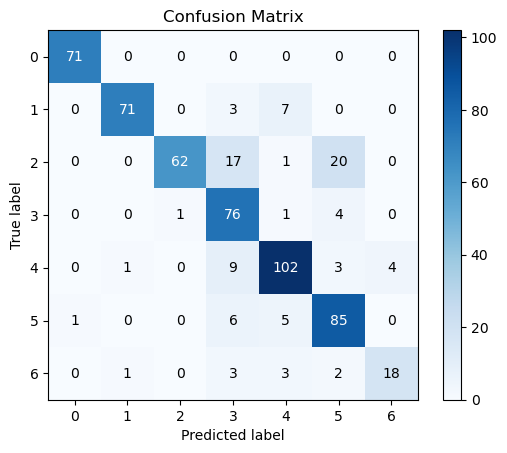

In [21]:
import scikitplot as skplt
from sklearn.metrics import classification_report

skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels)
print(classification_report(true_labels, predicted_labels, target_names=['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']))